In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

2024-10-28 13:41:58.070490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 13:41:58.088273: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 13:41:58.094103: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 13:41:58.136491: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


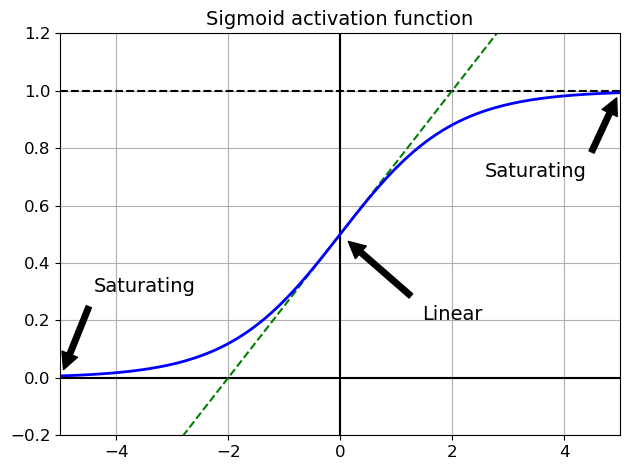

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

In [4]:
# Xavier and He initialisations

[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'IdentityInitializer',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'OrthogonalInitializer',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

<Dense name=dense, built=False>

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

<Dense name=dense_1, built=False>

In [7]:
# Nonsaturating activation functions

# Leaky ReLU
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


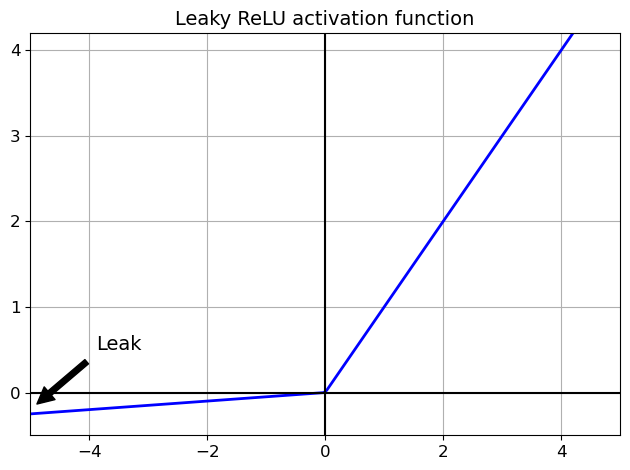

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'hard_silu',
 'hard_swish',
 'leaky_relu',
 'linear',
 'log_softmax',
 'mish',
 'relu',
 'relu6',
 'selu',
 'serialize',
 'sigmoid',
 'silu',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

In [11]:
# Let's train a neural network on Fashion MNIST using the Leaky ReLU

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

/home/ngu145/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1730083320.989831    7491 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730083321.091483    7491 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730083321.091641    7491 cuda_executor.cc:1015] successful NUMA node rea

In [13]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [14]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10


I0000 00:00:1730083322.323764  654183 service.cc:146] XLA service 0x77b3880062c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730083322.323782  654183 service.cc:154]   StreamExecutor device (0): Quadro RTX 5000 with Max-Q Design, Compute Capability 7.5
2024-10-28 13:42:02.348616: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-28 13:42:02.368653: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300


 268/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - accuracy: 0.2369 - loss: 2.2459

I0000 00:00:1730083322.798240  654183 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4998 - loss: 1.6113 - val_accuracy: 0.7320 - val_loss: 0.8295
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - accuracy: 0.7331 - loss: 0.8035 - val_accuracy: 0.7828 - val_loss: 0.6833
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step - accuracy: 0.7758 - loss: 0.6813 - val_accuracy: 0.8040 - val_loss: 0.6147
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/step - accuracy: 0.7949 - loss: 0.6187 - val_accuracy: 0.8160 - val_loss: 0.5730
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 651us/step - accuracy: 0.8069 - loss: 0.5792 - val_accuracy: 0.8232 - val_loss: 0.5445
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step - accuracy: 0.8145 - loss: 0.5515 - val_accuracy: 0.8296 - val_loss: 0.5236
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 644us/step - accuracy: 0.8208 - loss: 0.5307 - val_accuracy: 0.8334 - val_loss: 0.5075
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step - accuracy: 0.8251 - loss: 0.5145

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,612 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [16]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8247 - loss: 0.5108


[0.5172340869903564, 0.8206999897956848]

In [17]:
# Now let's try PReLU

tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [18]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [19]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4527 - loss: 1.6829 - val_accuracy: 0.7218 - val_loss: 0.9071
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 652us/step - accuracy: 0.7281 - loss: 0.8562 - val_accuracy: 0.7730 - val_loss: 0.7177
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 651us/step - accuracy: 0.7728 - loss: 0.7027 - val_accuracy: 0.7996 - val_loss: 0.6348
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step - accuracy: 0.7943 - loss: 0.6291 - val_accuracy: 0.8136 - val_loss: 0.5863
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step - accuracy: 0.8080 - loss: 0.5843 - val_accuracy: 0.8240 - val_loss: 0.5541
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step - accuracy: 0.8165 - loss: 0.5537 - val_accuracy: 0.8326 - val_loss: 0.5310
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step - accuracy: 0.8236 - loss: 0.5313 - val_accuracy: 0.8366 - val_loss: 0.5135
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - accuracy: 0.8284 - l

In [20]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8241 - loss: 0.5084


[0.5156813859939575, 0.821399986743927]

In [21]:
# ELU
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


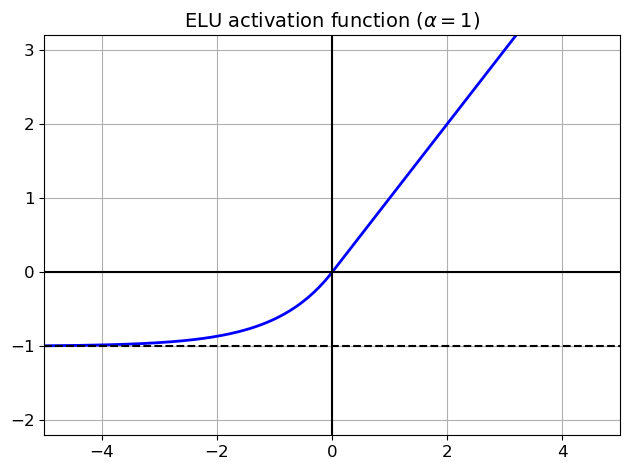

In [22]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

In [23]:
# SELU

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [24]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


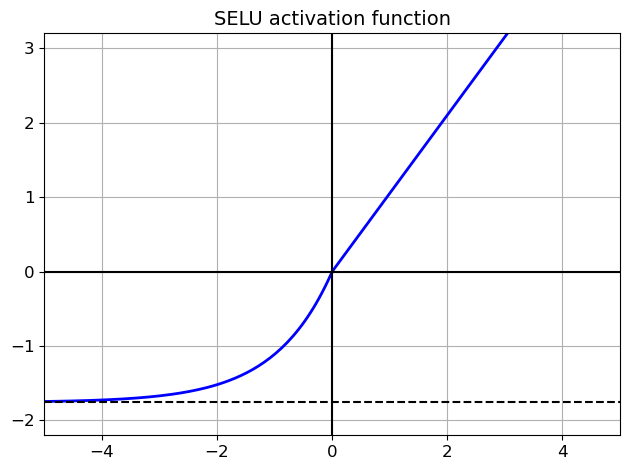

In [25]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

In [26]:
# By default, the SELU hyperparameters (scale and alpha) are tuned in such a way that the mean output of each neuron remains close to 0,
# and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too).
# Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all
# layers, avoiding the exploding/vanishing gradients problem:

np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [27]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

<Dense name=dense_8, built=False>

In [28]:
np.random.seed(42)
tf.random.set_seed(42)

In [29]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [30]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [31]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [32]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.4585 - loss: 1.4556 - val_accuracy: 0.6978 - val_loss: 0.8044
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7428 - loss: 0.7106 - val_accuracy: 0.7892 - val_loss: 0.5976
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8018 - loss: 0.5639 - val_accuracy: 0.8134 - val_loss: 0.5656
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8109 - loss: 0.5561 - val_accuracy: 0.8314 - val_loss: 0.5053
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8257 - loss: 0.5056 - val_accuracy: 0.7374 - val_loss: 0.8447


In [33]:
# Compare with ReLU

np.random.seed(42)
tf.random.set_seed(42)

In [34]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [35]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [36]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.1300 - loss: 2.2701 - val_accuracy: 0.2828 - val_loss: 1.8671
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2461 - loss: 1.9110 - val_accuracy: 0.2480 - val_loss: 1.7154
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4173 - loss: 1.4195 - val_accuracy: 0.4942 - val_loss: 1.7343
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5829 - loss: 1.0076 - val_accuracy: 0.5648 - val_loss: 1.1292
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6057 - loss: 0.9792 - val_accuracy: 0.6386 - val_loss: 0.9078


In [37]:
# The above comparison shows we still suffer from the vanishing gradient problem with ReLU

# BATCH NORMALISATION
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [38]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 784)            │         3,136 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,346 (1.04 MB)

 Trainable params: 268,978 (1.03 MB)

 Non-trainable params: 2,368 (9.25 KB)

In [39]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('gamma', True),
 ('beta', True),
 ('moving_mean', False),
 ('moving_variance', False)]

In [40]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [41]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6001 - loss: 1.2314 - val_accuracy: 0.8080 - val_loss: 0.5738
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - accuracy: 0.7930 - loss: 0.6007 - val_accuracy: 0.8320 - val_loss: 0.4886
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - accuracy: 0.8191 - loss: 0.5235 - val_accuracy: 0.8452 - val_loss: 0.4497
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - accuracy: 0.8330 - loss: 0.4818 - val_accuracy: 0.8518 - val_loss: 0.4266
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - accuracy: 0.8429 - loss: 0.4535 - val_accuracy: 0.8570 - val_loss: 0.4106
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step - accuracy: 0.8505 - loss: 0.4321 - val_accuracy: 0.8606 - val_loss: 0.3988
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step - accuracy: 0.8559 - loss: 0.4150 - val_accuracy: 0.8640 - val_loss: 0.3894
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 778us/step - accuracy: 0.8600 - l

In [64]:
# Apply BN before the activation function

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [43]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [44]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5370 - loss: 1.4371 - val_accuracy: 0.7862 - val_loss: 0.6747
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step - accuracy: 0.7737 - loss: 0.7086 - val_accuracy: 0.8180 - val_loss: 0.5527
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - accuracy: 0.8037 - loss: 0.6026 - val_accuracy: 0.8342 - val_loss: 0.4980
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - accuracy: 0.8188 - loss: 0.5486 - val_accuracy: 0.8438 - val_loss: 0.4653
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - accuracy: 0.8293 - loss: 0.5136 - val_accuracy: 0.8500 - val_loss: 0.4431
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - accuracy: 0.8368 - loss: 0.4882 - val_accuracy: 0.8544 - val_loss: 0.4266
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - accuracy: 0.8424 - loss: 0.4683 - val_accuracy: 0.8574 - val_loss: 0.4139
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - accuracy: 0.8472 - l

In [45]:
# Faster optimizers
# Using Nesterov accelerated gradient

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, nesterov=True),
              metrics=["accuracy"])

In [46]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8572 - loss: 0.4139 - val_accuracy: 0.8762 - val_loss: 0.3571
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.8751 - loss: 0.3585 - val_accuracy: 0.8810 - val_loss: 0.3389
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.8888 - loss: 0.3219 - val_accuracy: 0.8840 - val_loss: 0.3288
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.8984 - loss: 0.2930 - val_accuracy: 0.8866 - val_loss: 0.3220
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.9082 - loss: 0.2680 - val_accuracy: 0.8854 - val_loss: 0.3197
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - accuracy: 0.9158 - loss: 0.2456 - val_accuracy: 0.8868 - val_loss: 0.3195
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.9238 - loss: 0.2251 - val_accuracy: 0.8878 - val_loss: 0.3197
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.9330 - l

In [47]:
# Using Adam optimizer

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"])

In [48]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8485 - loss: 0.4196 - val_accuracy: 0.8714 - val_loss: 0.3543
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step - accuracy: 0.8845 - loss: 0.3178 - val_accuracy: 0.8802 - val_loss: 0.3343
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step - accuracy: 0.8989 - loss: 0.2784 - val_accuracy: 0.8848 - val_loss: 0.3244
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 848us/step - accuracy: 0.9119 - loss: 0.2435 - val_accuracy: 0.8884 - val_loss: 0.3244
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - accuracy: 0.9224 - loss: 0.2143 - val_accuracy: 0.8878 - val_loss: 0.3370
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 870us/step - accuracy: 0.9297 - loss: 0.1908 - val_accuracy: 0.8846 - val_loss: 0.3490
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step - accuracy: 0.9403 - loss: 0.1652 - val_accuracy: 0.8888 - val_loss: 0.3514
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step - accuracy: 0.9488 - l

In [49]:
# Non-constant learning rate with exponential scheduling
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

In [50]:
exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [51]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 879us/step - accuracy: 0.8279 - loss: 0.5131 - val_accuracy: 0.8708 - val_loss: 0.3569 - learning_rate: 0.0100
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - accuracy: 0.8780 - loss: 0.3302 - val_accuracy: 0.8770 - val_loss: 0.3537 - learning_rate: 0.0089
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 869us/step - accuracy: 0.8886 - loss: 0.2964 - val_accuracy: 0.8864 - val_loss: 0.3480 - learning_rate: 0.0079
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - accuracy: 0.9023 - loss: 0.2623 - val_accuracy: 0.8832 - val_loss: 0.3699 - learning_rate: 0.0071
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step - accuracy: 0.9138 - loss: 0.2285 - val_accuracy: 0.8864 - val_loss: 0.3745 - learning_rate: 0.0063
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step - accuracy: 0.9258 - loss: 0.1972 - val_accuracy: 0.8882 - val_loss: 0.4010 - learning_rate: 0.0056
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 859us/step - accura

In [54]:
# Alternatively, using keras.optimizers.schdules.ExponentialDecay() to implement the same thing
s = 20 * len(X_train) // 32 # Number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate),
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9545 - loss: 0.1219 - val_accuracy: 0.8884 - val_loss: 0.5662
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - accuracy: 0.9608 - loss: 0.1044 - val_accuracy: 0.8900 - val_loss: 0.5588
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - accuracy: 0.9631 - loss: 0.0976 - val_accuracy: 0.8906 - val_loss: 0.5557
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step - accuracy: 0.9647 - loss: 0.0934 - val_accuracy: 0.8904 - val_loss: 0.5542
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - accuracy: 0.9663 - loss: 0.0905 - val_accuracy: 0.8900 - val_loss: 0.5538
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - accuracy: 0.9669 - loss: 0.0884 - val_accuracy: 0.8906 - val_loss: 0.5537
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step - accuracy: 0.9678 - loss: 0.0868 - val_accuracy: 0.8910 - val_loss: 0.5538
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - accuracy: 0.9683 - l

In [61]:
# Avoid overfitting through regularization

from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

In [65]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7976 - loss: 0.5759 - val_accuracy: 0.8714 - val_loss: 0.3407
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 868us/step - accuracy: 0.8686 - loss: 0.3568 - val_accuracy: 0.8806 - val_loss: 0.3232
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step - accuracy: 0.8874 - loss: 0.3061 - val_accuracy: 0.8876 - val_loss: 0.3125
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step - accuracy: 0.9023 - loss: 0.2659 - val_accuracy: 0.8866 - val_loss: 0.3088
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step - accuracy: 0.9139 - loss: 0.2352 - val_accuracy: 0.8892 - val_loss: 0.3204
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - accuracy: 0.9254 - loss: 0.2042 - val_accuracy: 0.8912 - val_loss: 0.3287
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step - accuracy: 0.9366 - loss: 0.1784 - val_accuracy: 0.8878 - val_loss: 0.3552
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 850us/step - accuracy: 0.9450 - l

In [89]:
# Dropout

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(10, activation="softmax")
])

In [90]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7633 - loss: 0.6515 - val_accuracy: 0.8632 - val_loss: 0.3857
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - accuracy: 0.8394 - loss: 0.4268 - val_accuracy: 0.8754 - val_loss: 0.3524
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step - accuracy: 0.8526 - loss: 0.3917 - val_accuracy: 0.8754 - val_loss: 0.3455
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.8629 - loss: 0.3664 - val_accuracy: 0.8742 - val_loss: 0.3291
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - accuracy: 0.8687 - loss: 0.3464 - val_accuracy: 0.8782 - val_loss: 0.3202
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - accuracy: 0.8774 - loss: 0.3298 - val_accuracy: 0.8876 - val_loss: 0.3108
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - accuracy: 0.8822 - loss: 0.3153 - val_accuracy: 0.8806 - val_loss: 0.3229
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - accuracy: 0.8823 - l